# Logistic Regression Pipeline for H1ESC (GREG)

### Author : Shaurya Jauhari
### Last Reviewed : December 7th 2020

## Prologue

This notebook assesses variaegated implementations of the logistic regression models for the data dervied from the H1ESC cell-line in GREG. The data for the same and other cell-types for GREG is available at this <a href = "https://zenodo.org/deposit/4265559"> link</a>.

## Contents

* [1. Loading Packages](#link1)
* [2. Loading Data](#link2)
* [3. Building Model](#link3)
* [4. Dealing with the *Paradox* of Accuracy ](#link4)
    * [4.1 Problem of Class Imbalance](#link5)
        * [4.1.1 Oversampling of minority class](#link6)
        * [4.1.2 Undersampling of minority class](#link7)
        * [4.1.3 SMOTE](#link8)
        * [4.1.4 Both over- and under-sampling](#link9)
* [5. Ratifying the *Pareto's Principle*](#link10)
    * [5.1 SMOTE data](#link11)
* [6. Visualizing Predictions](#link12)
* [7. Session Information](#link13)

### <a id=link1>1. Loading Packages </a>

In [12]:
requiredPackages <- c("glmnet", "rms", "caret", "e1071", "ROSE", "DMwR", "BiocManager", "ROCR")
newPackages <- requiredPackages[!(requiredPackages %in% installed.packages()[,"Package"])]
if(length(newPackages)) install.packages(newPackages, dependencies = TRUE)

suppressPackageStartupMessages(library(glmnet))
suppressPackageStartupMessages(library(rms))
suppressPackageStartupMessages(library(caret))
suppressPackageStartupMessages(library(e1071))
suppressPackageStartupMessages(library(ROSE))
suppressPackageStartupMessages(library(DMwR))
suppressPackageStartupMessages(library(ROCR))

### <a id=link2>2. Loading Data </a>

In [2]:
h1escgregStandard <- read.table("../../transcriptionFactoriesGREG/MachineLearning/data/H1ESCforML.txt", header = TRUE) ## loading data
h1escgreg<- h1escgregStandard[, -c(1:3)] ## removing the first three columns for non-usage in the ML model.

In [3]:
head(h1escgreg)

,CTCF,EP300,H3K27me3,H3K36me3,H3K4me1,H3K4me2,H3K4me3,H3K9ac,H3K9me3,RAD21,RNA.Seq,RNAPol2,YY1,Class
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,0.00000,0.0000000,0.000000,0.0000,0.0000000,0.0000000,0,0.000000,0.0000000,0.000000,0,0.00000000,0.0000000,Non-Hub
2,0.00000,0.0000000,0.000000,0.0000,0.0000000,0.0000000,0,0.000000,0.0000000,0.000000,0,0.00000000,0.0000000,Non-Hub
3,0.00000,0.0000000,0.000000,0.0000,0.0000000,0.0000000,0,0.000000,0.0000000,0.000000,0,0.00000000,0.0000000,Non-Hub
4,0.00000,0.0000000,0.000000,0.0000,0.0000000,0.0000000,0,0.000000,0.0000000,0.000000,0,0.00000000,0.0000000,Non-Hub
5,0.00000,0.2230824,0.000000,0.0000,0.0000000,0.0000000,0,0.000000,0.0000000,0.000000,0,0.02765707,0.0000000,Non-Hub
6,35.88248,0.3718039,1.424037,1.3575,0.7813343,0.7305773,0,1.444572,0.1266057,0.279418,0,0.19359947,0.1803093,Non-Hub


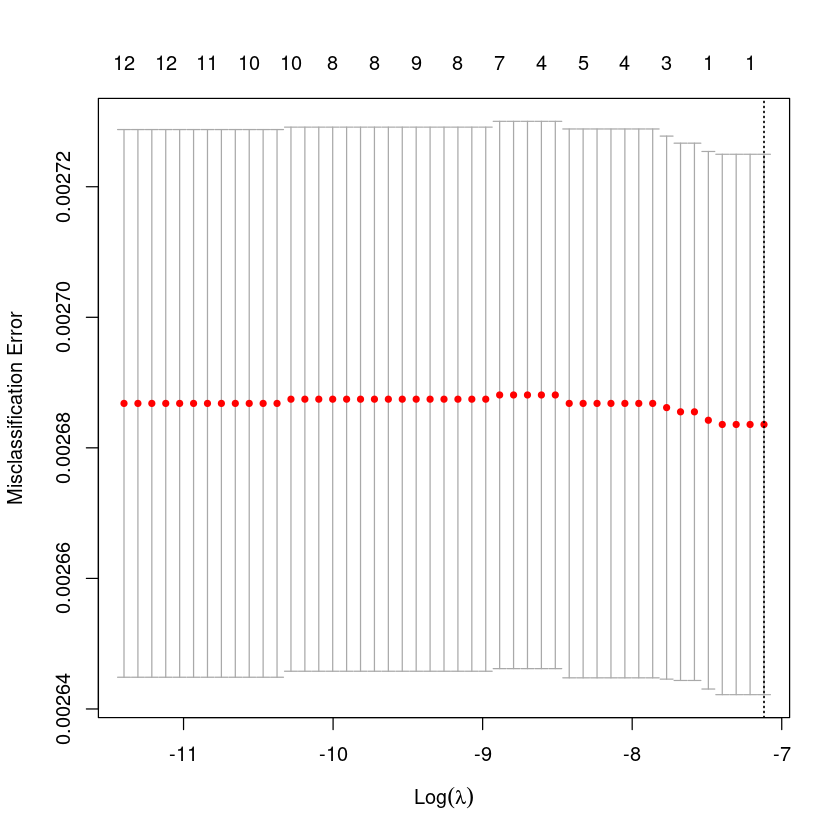

In [6]:
set.seed(005)
cv.modelfit <- cv.glmnet(as.matrix(h1escgreg[,1:13]),
                         h1escgreg$Class,
                         family = "binomial",
                         type.measure = "class",
                         alpha = 1,
                         nlambda = 100)


plot(cv.modelfit)

In [7]:
cat("There are", length(cv.modelfit$lambda),
    "lambda values in all:\n",
    cv.modelfit$lambda,
    "\n, out of which",
    min(cv.modelfit$lambda),
    "is the minimum, while",
    cv.modelfit$lambda.1se,
    "denotes the value at which the model is optimized at one standard error.")

There are 47 lambda values in all:
 0.0008099085 0.0007379584 0.0006724002 0.0006126661 0.0005582385 0.0005086461 0.0004634594 0.000422287 0.0003847721 0.00035059 0.0003194446 0.000291066 0.0002652085 0.0002416481 0.0002201808 0.0002006205 0.0001827979 0.0001665587 0.0001517621 0.0001382799 0.0001259955 0.0001148024 0.0001046037 9.5311e-05 8.684383e-05 7.912886e-05 7.209927e-05 6.569417e-05 5.985808e-05 5.454046e-05 4.969523e-05 4.528045e-05 4.125786e-05 3.759262e-05 3.4253e-05 3.121005e-05 2.843744e-05 2.591114e-05 2.360926e-05 2.151188e-05 1.960082e-05 1.785954e-05 1.627295e-05 1.48273e-05 1.351009e-05 1.230989e-05 1.121631e-05 
, out of which 1.121631e-05 is the minimum, while 0.0008099085 denotes the value at which the model is optimized at one standard error.

### <a id=link3>3. Building Model </a>

In [ ]:
set.seed(2)
modelfit <- glmnet(as.matrix(h1escgreg[,1:13]),
                   h1escgreg$Class,
                   family = "binomial",
                   alpha = 1,
                   lambda = min(cv.modelfit$lambda))

# Listing non-zero coefficients
print(modelfit$beta[,1])

For a standard usage, supplying a single <i>lambda</i> value is not advisable (See <a href= "https://cran.r-project.org/web/packages/glmnet/glmnet.pdf" > here</a>). There could be a convergence issue, as above, and so the better way is to have the function decide for itself amongst an array of values. Let us attempt again, with the new theme.

In [8]:
set.seed(3)
modelfit <- glmnet(as.matrix(h1escgreg[,1:13]),
                   h1escgreg$Class,
                   family = "binomial",
                   alpha = 1,
                   lambda = cv.modelfit$lambda)
# Listing non-zero coefficients
print(modelfit$beta[,1])

         CTCF         EP300      H3K27me3      H3K36me3       H3K4me1 
 0.000000e+00 -2.693701e-16  0.000000e+00  0.000000e+00  0.000000e+00 
      H3K4me2       H3K4me3        H3K9ac       H3K9me3         RAD21 
 0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00 
      RNA.Seq       RNAPol2           YY1 
 0.000000e+00  0.000000e+00  0.000000e+00 


In [9]:
coef(modelfit)[,1]
predict(modelfit, type="coef")

(Intercept)          CTCF         EP300      H3K27me3      H3K36me3 
 5.917916e+00  0.000000e+00 -2.693701e-16  0.000000e+00  0.000000e+00 
      H3K4me1       H3K4me2       H3K4me3        H3K9ac       H3K9me3 
 0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00 
        RAD21       RNA.Seq       RNAPol2           YY1 
 0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00

   [[ suppressing 47 column names ‘s0’, ‘s1’, ‘s2’ ... ]]



14 x 47 sparse Matrix of class "dgCMatrix"
                                                                        
(Intercept)  5.917916e+00  5.93250310  5.9369254  5.93953473  5.94145779
CTCF         .             .           .          .           .         
EP300       -2.693701e-16 -0.02236828 -0.0289948 -0.03284231 -0.03564675
H3K27me3     .             .           .          .           .         
H3K36me3     .             .           .          .           .         
H3K4me1      .             .           .          .           .         
H3K4me2      .             .           .          .           .         
H3K4me3      .             .           .          .           .         
H3K9ac       .             .           .          .           .         
H3K9me3      .             .           .          .           .         
RAD21        .             .           .          .           .         
RNA.Seq      .             .           .          .           .         
RNAPol2 

In [3]:
set.seed(4) # for reproducibility of results.

h1escgreg$Class <- as.numeric(as.factor(h1escgreg$Class))
h1escgreg$Class <- ifelse(h1escgreg$Class == 2, 0, 1)

# partitioning data into training and testing subsets

part <- sample(2, nrow(h1escgreg),
               replace = TRUE,
               prob = c(0.7,0.3))
train <- h1escgreg[part==1,]
test <- h1escgreg[part==2,]
cat("So, now we have",
    nrow(train),
    "training rows and",
    nrow(test),
    "testing rows")

# building model

h1escmodel <- glm(formula = Class ~ .,
               data = train,
               family = "binomial")
summary(h1escmodel)

So, now we have 1084535 training rows and 464887 testing rows

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”



Call:
glm(formula = Class ~ ., family = "binomial", data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.2258  -0.0748  -0.0716  -0.0681   3.8551  

Coefficients:
              Estimate Std. Error  z value Pr(>|z|)    
(Intercept) -6.1071120  0.0280476 -217.741  < 2e-16 ***
CTCF        -0.0744010  0.0224502   -3.314  0.00092 ***
EP300        0.0796677  0.0195032    4.085 4.41e-05 ***
H3K27me3     0.0205721  0.0045987    4.473 7.70e-06 ***
H3K36me3     0.0716736  0.0182670    3.924 8.72e-05 ***
H3K4me1      0.1405031  0.0262222    5.358 8.41e-08 ***
H3K4me2     -0.0548733  0.0182348   -3.009  0.00262 ** 
H3K4me3      0.1434262  0.0196805    7.288 3.15e-13 ***
H3K9ac      -0.2069055  0.0319185   -6.482 9.03e-11 ***
H3K9me3      0.0080277  0.0318560    0.252  0.80104    
RAD21        0.1175671  0.0229053    5.133 2.86e-07 ***
RNA.Seq      0.0008596  0.0006769    1.270  0.20410    
RNAPol2      0.0152003  0.0097391    1.561  0.11858    
YY1         -0.00750

<h5> Variance Inflation Factors (VIF) </h5>


<p align= "justify"> The state of <a href = "https://www.investopedia.com/terms/m/multicollinearity.asp" > multicollinearity</a> is a common check enroute building of an effective regression model. When two or more predictor(independent) variables are correlated with each other, they do not offer much to the model structure and kind of induce <i>redundancy</i>.</p>
<p align="justify"> A general guideline is that a VIF larger than 5, then that predictor is more related to the other predictors than it is to the response. Contrarily, a VIF value of 1 for a predictor variable indicates that there is no correlation with other predictors, and a VIF value between 1 and 5 is representative of a moderate correlation. <b>The user can choose to remove the independent variables with a high VIF and a high p-value</b>.</p>

In [5]:
vif(h1escmodel)

CTCF     EP300  H3K27me3  H3K36me3   H3K4me1   H3K4me2   H3K4me3    H3K9ac 
10.485787  3.858458  1.821899 15.356743  7.723808  9.511523  9.682681 21.780140 
  H3K9me3     RAD21   RNA.Seq   RNAPol2       YY1 
 2.103323  4.878538  1.030444  2.133204  5.219354

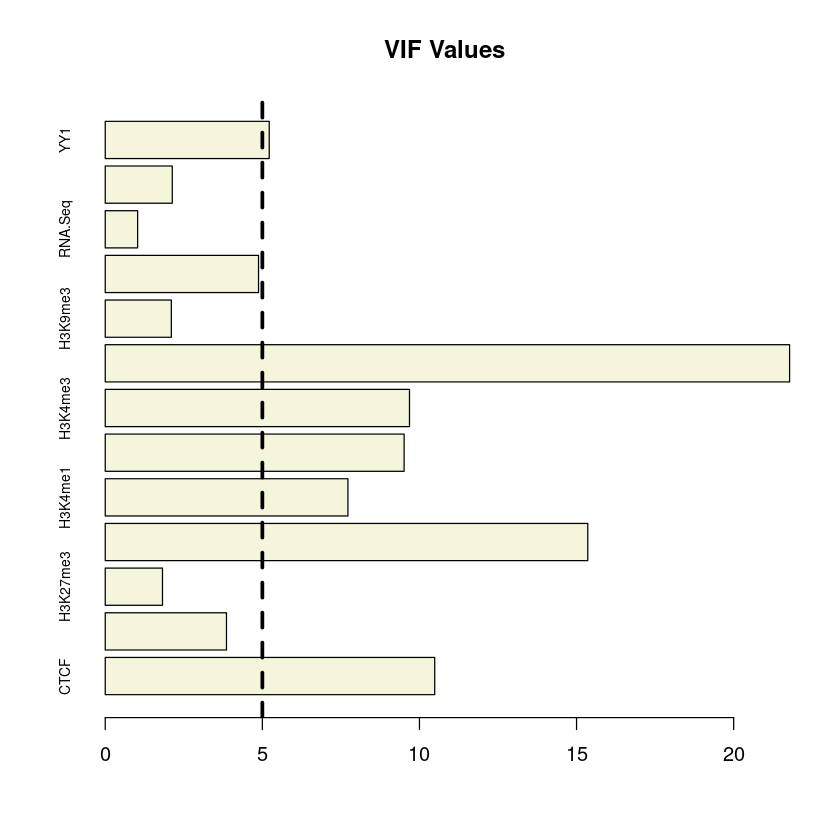

In [6]:
#create horizontal bar chart to display each VIF value
barplot(vif(h1escmodel), main = "VIF Values", horiz = TRUE, col = "beige", cex.names=.7)

#add vertical line at 5
abline(v = 5, lwd = 3, lty = 2)

Initial observation is that amongst others, the variable <b>YY1</b> has a high p-value and a marginally high VIF (5.22). In contrast, <b>H3K4me2</b> has a low p-value (0.01) and a high VIF (9.51). In such a case, the former can be omitted from the model. Let us re-design the model without YY1.  

In [7]:
h1escmodel1 <- glm(formula = Class ~ CTCF + EP300 + H3K27me3 + H3K36me3 + H3K4me1 + H3K4me2 + H3K4me3 + H3K9ac + H3K9me3 + RAD21 + RNAPol2,
               data = train,
               family = "binomial")
summary(h1escmodel1)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”



Call:
glm(formula = Class ~ CTCF + EP300 + H3K27me3 + H3K36me3 + H3K4me1 + 
    H3K4me2 + H3K4me3 + H3K9ac + H3K9me3 + RAD21 + RNAPol2, family = "binomial", 
    data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.3197  -0.0748  -0.0716  -0.0681   3.8591  

Coefficients:
             Estimate Std. Error  z value Pr(>|z|)    
(Intercept) -6.105361   0.027901 -218.819  < 2e-16 ***
CTCF        -0.074510   0.022482   -3.314 0.000919 ***
EP300        0.075579   0.015686    4.818 1.45e-06 ***
H3K27me3     0.020446   0.004596    4.448 8.65e-06 ***
H3K36me3     0.075434   0.017513    4.307 1.65e-05 ***
H3K4me1      0.139531   0.026240    5.317 1.05e-07 ***
H3K4me2     -0.055240   0.018225   -3.031 0.002438 ** 
H3K4me3      0.144126   0.019685    7.322 2.45e-13 ***
H3K9ac      -0.211779   0.031238   -6.780 1.21e-11 ***
H3K9me3      0.006299   0.031897    0.197 0.843452    
RAD21        0.115867   0.022419    5.168 2.36e-07 ***
RNAPol2      0.015370   0.009444  

In [8]:
# Examine the VIF for the variables in the new model.
vif(h1escmodel1)

CTCF     EP300  H3K27me3  H3K36me3   H3K4me1   H3K4me2   H3K4me3    H3K9ac 
10.366810  2.397840  1.808430 13.883554  7.629533  9.468991  9.681347 20.525082 
  H3K9me3     RAD21   RNAPol2 
 2.082880  4.608605  1.992745

This seems a good improvisation than before as just two variables (<i>H3K9me3</i> and <i>RNAPol2</i>) demonstrate a high p-value, but an acceptable VIF. We'll stick to this model.

In [9]:
yTrain <- predict(h1escmodel1, train, type = "response")
head(yTrain)

1            2            3            4            6           10 
0.0022259106 0.0022259106 0.0022259106 0.0022259106 0.0001476553 0.0023507714

In [10]:
head(train)

,CTCF,EP300,H3K27me3,H3K36me3,H3K4me1,H3K4me2,H3K4me3,H3K9ac,H3K9me3,RAD21,RNA.Seq,RNAPol2,YY1,Class
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.0000000,0.0000000,0.0000000,0.0000,0.0000000,0.0000000,0,0.000000,0.0000000,0.000000,0.00000,0.0000000,0.0000000,0
2,0.0000000,0.0000000,0.0000000,0.0000,0.0000000,0.0000000,0,0.000000,0.0000000,0.000000,0.00000,0.0000000,0.0000000,0
3,0.0000000,0.0000000,0.0000000,0.0000,0.0000000,0.0000000,0,0.000000,0.0000000,0.000000,0.00000,0.0000000,0.0000000,0
4,0.0000000,0.0000000,0.0000000,0.0000,0.0000000,0.0000000,0,0.000000,0.0000000,0.000000,0.00000,0.0000000,0.0000000,0
6,35.8824840,0.3718039,1.4240371,1.3575,0.7813343,0.7305773,0,1.444572,0.1266057,0.279418,0.00000,0.1935995,0.1803093,0
10,0.8751825,0.0000000,0.8215599,2.7150,1.1329347,0.4522622,0,1.108625,0.0000000,0.000000,11.44359,0.0000000,0.0000000,0



Attaching package: ‘e1071’


The following object is masked from ‘package:Hmisc’:

    impute



Attaching package: ‘caret’


The following object is masked from ‘package:survival’:

    cluster




The confusion matrix is
         Actual
Predicted      0      1
        0 463653   1232
        1      2      0
The accuracy of the model is 99.73456 % 
The misclassification error of the model is 0.2654408 % 
The sensitivity of the model is 99.99957 % 
The specificity of the model is 0 % 
The area under curve is 0.4999978 
The statistical significance for the model is 9.416662e-47 
The confidence level for the model is 100 %

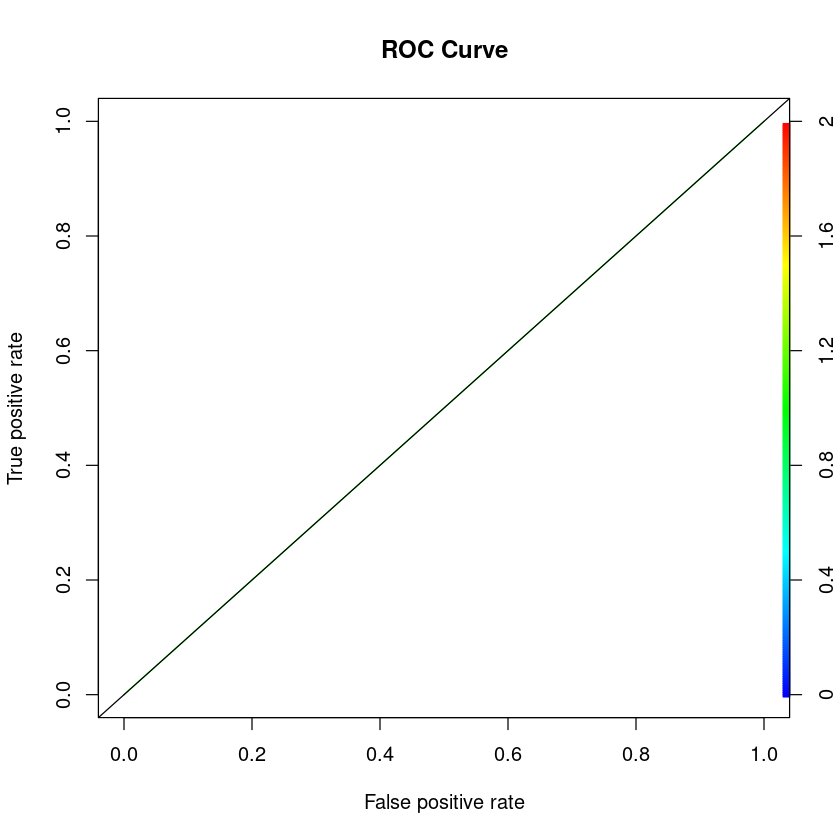

In [11]:
source("../../transcriptionFactoriesGREG/MachineLearning/R/modelPerformance.R")
modelPerformance(h1escmodel1, "lr", test, Class)

We can clearly observe that the model has **zero specificity** and **high sensitivity**.. It means that the model is **highly biased towards the Non-Hubs** and that solely accounts for the data imbalance.

### <a id=link4>4. Dealing with the *Paradox* of Accuracy  </a>

The model is highly accurate in predicting the non-hubs individually. Since the data carries significant imbalance in the classes (non-hubs are far more in number than the hubs), the prediction for the hubs might not be well suited. We need to extend the analysis for a "balanced" data. But before we delve further, let us calculate the sensitivity and specificity parameters to check how well the model is able to identify positive class labels (1: hubs).

This is clearly not what we want.

####  <a id=link5>4.1 Problem of Class Imbalance </a>

The problem of class imbalance presents a warranting scenario for data normalization in terms of class proportions. Two simple strategies to mitigate this problem are oversampling and undersampling.

#####  <a id=link5> 4.1.1 Oversampling of minority class </a>

In [13]:
table(h1escgreg$Class)


      0       1 
1545264    4158 

We can articulate that the hubs(class marked with '0') are way less than the non-hubs. To scale them in proportion to the non-hubs, we can choose to oversample their instances. This is carried out by randomly choosing their exisiting data points and repeating to match a specified number. The package ***ROSE*** comes in handy here. The details about the package could be found [here](https://www.rdocumentation.org/packages/ROSE/versions/0.0-3).

In [14]:
overTrain <- ovun.sample(Class ~., data = train, method = "over", N = 1549422)$data

In [15]:
table(overTrain$Class)


      0       1 
1081609  467813 

Still better. Let's run the model again to see if there is any improvement in the performance.

In [16]:
h1escmodel1Over <- glm(formula = Class ~ CTCF + EP300 + H3K27me3 + H3K36me3 + H3K4me1 + H3K4me2 + H3K4me3 + H3K9ac + H3K9me3 + RAD21 + RNAPol2,
               data = overTrain,
               family = "binomial")
summary(h1escmodel1Over)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”



Call:
glm(formula = Class ~ CTCF + EP300 + H3K27me3 + H3K36me3 + H3K4me1 + 
    H3K4me2 + H3K4me3 + H3K9ac + H3K9me3 + RAD21 + RNAPol2, family = "binomial", 
    data = overTrain)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-8.4904  -0.8527  -0.7604   1.4001   1.8811  

Coefficients:
              Estimate Std. Error  z value Pr(>|z|)    
(Intercept) -1.3654001  0.0036533 -373.747  < 2e-16 ***
CTCF        -0.0712175  0.0021527  -33.083  < 2e-16 ***
EP300        0.5182176  0.0044976  115.220  < 2e-16 ***
H3K27me3     0.0260836  0.0006745   38.669  < 2e-16 ***
H3K36me3     0.1549167  0.0021757   71.205  < 2e-16 ***
H3K4me1      0.0491044  0.0028842   17.026  < 2e-16 ***
H3K4me2     -0.0648200  0.0021439  -30.235  < 2e-16 ***
H3K4me3      0.0980011  0.0026501   36.979  < 2e-16 ***
H3K9ac      -0.0572795  0.0032755  -17.487  < 2e-16 ***
H3K9me3     -0.0189412  0.0033865   -5.593 2.23e-08 ***
RAD21        0.1062130  0.0024849   42.744  < 2e-16 ***
RNAPol2     -0.025

In [17]:
vif(h1escmodel1Over)

CTCF    EP300 H3K27me3 H3K36me3  H3K4me1  H3K4me2  H3K4me3   H3K9ac 
3.098330 1.828552 1.248110 1.191863 2.148590 7.260030 9.816373 4.345412 
 H3K9me3    RAD21  RNAPol2 
1.136125 3.200349 2.408734

The confusion matrix is
         Actual
Predicted      0      1
        0 455097   1176
        1   8558     56
The accuracy of the model is 97.90616 % 
The misclassification error of the model is 2.093842 % 
The sensitivity of the model is 98.15423 % 
The specificity of the model is 4.545455 % 
The area under curve is 0.5134984 
The statistical significance for the model is 0 
The confidence level for the model is 100 %

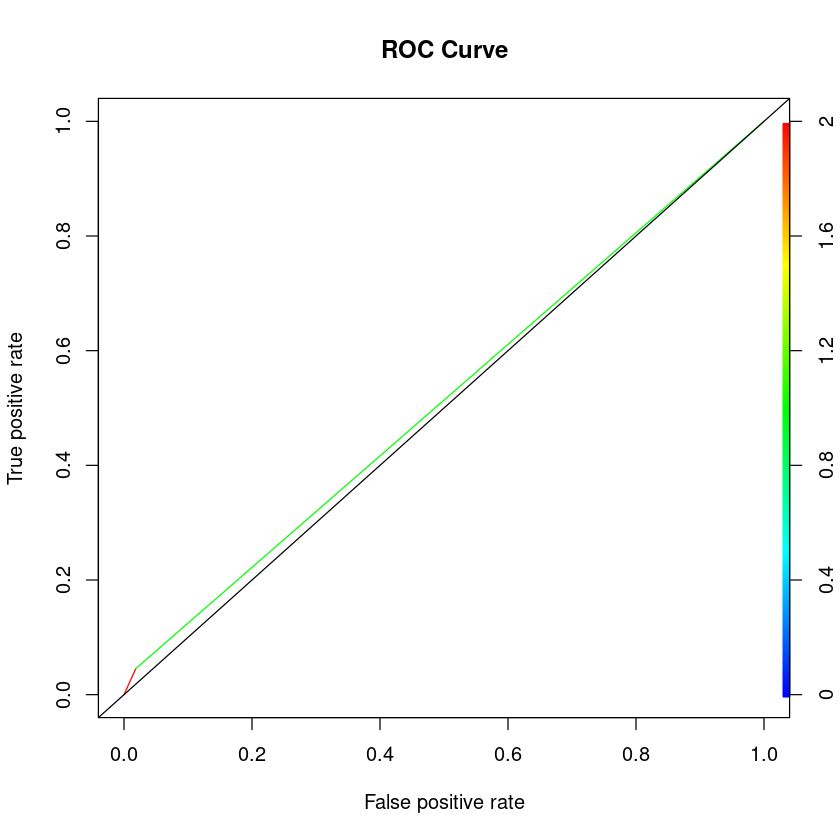

In [18]:
modelPerformance(h1escmodel1Over, "lr", test, Class)

This is better than before but still not good enough. Maybe we can try the other approach.

##### <a id=link5> 4.1.2 Undersampling of majority class  </a>

Contrary to what we did above, we shall now scale down the random data points from the majority class and see if the model performs any better.

In [19]:
underTrain <- ovun.sample(Class ~., data = train, method = "under", N= 6000)$data
table(underTrain$Class)


   0    1 
3074 2926 

In [20]:
h1escmodel1Under <- glm(formula = Class ~ CTCF + EP300 + H3K27me3 + H3K36me3 + H3K4me1 + H3K4me2 + H3K4me3 + H3K9ac + H3K9me3 + RAD21 + RNAPol2,
               data = underTrain,
               family = "binomial")
summary(h1escmodel1Under)


Call:
glm(formula = Class ~ CTCF + EP300 + H3K27me3 + H3K36me3 + H3K4me1 + 
    H3K4me2 + H3K4me3 + H3K9ac + H3K9me3 + RAD21 + RNAPol2, family = "binomial", 
    data = underTrain)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.8696  -1.1185  -0.8783   1.1866   1.6739  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.73405    0.05616 -13.069  < 2e-16 ***
CTCF        -0.05371    0.03686  -1.457  0.14512    
EP300        0.62664    0.07301   8.583  < 2e-16 ***
H3K27me3     0.01277    0.01028   1.243  0.21400    
H3K36me3     0.14814    0.03400   4.357 1.32e-05 ***
H3K4me1      0.04594    0.04585   1.002  0.31636    
H3K4me2     -0.00350    0.03770  -0.093  0.92603    
H3K4me3      0.06404    0.04431   1.445  0.14838    
H3K9ac      -0.03822    0.05189  -0.737  0.46139    
H3K9me3      0.08526    0.05572   1.530  0.12600    
RAD21        0.12054    0.04453   2.707  0.00678 ** 
RNAPol2     -0.05311    0.02234  -2.377  0.01744 *  


In [21]:
vif(h1escmodel1Under)

CTCF     EP300  H3K27me3  H3K36me3   H3K4me1   H3K4me2   H3K4me3    H3K9ac 
 2.933773  1.765700  1.141923  1.195689  1.960710  6.602956 10.056704  5.938884 
  H3K9me3     RAD21   RNAPol2 
 1.162425  3.173569  3.662354

We can observe that **H3K4me3** has a high VIF and a low statistical significance. Let us omit this variable and reaccess the model's performance.

In [22]:
h1escmodel2Under <- glm(formula = Class ~ CTCF + EP300 + H3K27me3 + H3K36me3 + H3K4me1 + H3K4me2 + H3K9ac + H3K9me3 + RAD21 + RNAPol2,
               data = underTrain,
               family = "binomial")
summary(h1escmodel2Under)


Call:
glm(formula = Class ~ CTCF + EP300 + H3K27me3 + H3K36me3 + H3K4me1 + 
    H3K4me2 + H3K9ac + H3K9me3 + RAD21 + RNAPol2, family = "binomial", 
    data = underTrain)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.8564  -1.1190  -0.8779   1.1865   1.8249  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.735277   0.056108 -13.105  < 2e-16 ***
CTCF        -0.054954   0.036857  -1.491  0.13595    
EP300        0.620228   0.072849   8.514  < 2e-16 ***
H3K27me3     0.011021   0.010095   1.092  0.27497    
H3K36me3     0.145735   0.033920   4.296 1.74e-05 ***
H3K4me1      0.022983   0.043113   0.533  0.59396    
H3K4me2      0.041863   0.022066   1.897  0.05781 .  
H3K9ac       0.005575   0.041401   0.135  0.89288    
H3K9me3      0.095918   0.055231   1.737  0.08245 .  
RAD21        0.122707   0.044563   2.754  0.00589 ** 
RNAPol2     -0.052460   0.022163  -2.367  0.01793 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.0

The confusion matrix is
         Actual
Predicted      0      1
        0 305094    685
        1 158561    547
The accuracy of the model is 65.74522 % 
The misclassification error of the model is 34.25478 % 
The sensitivity of the model is 65.80194 % 
The specificity of the model is 44.39935 % 
The area under curve is 0.5510065 
The statistical significance for the model is 9.261982e-56 
The confidence level for the model is 100 %

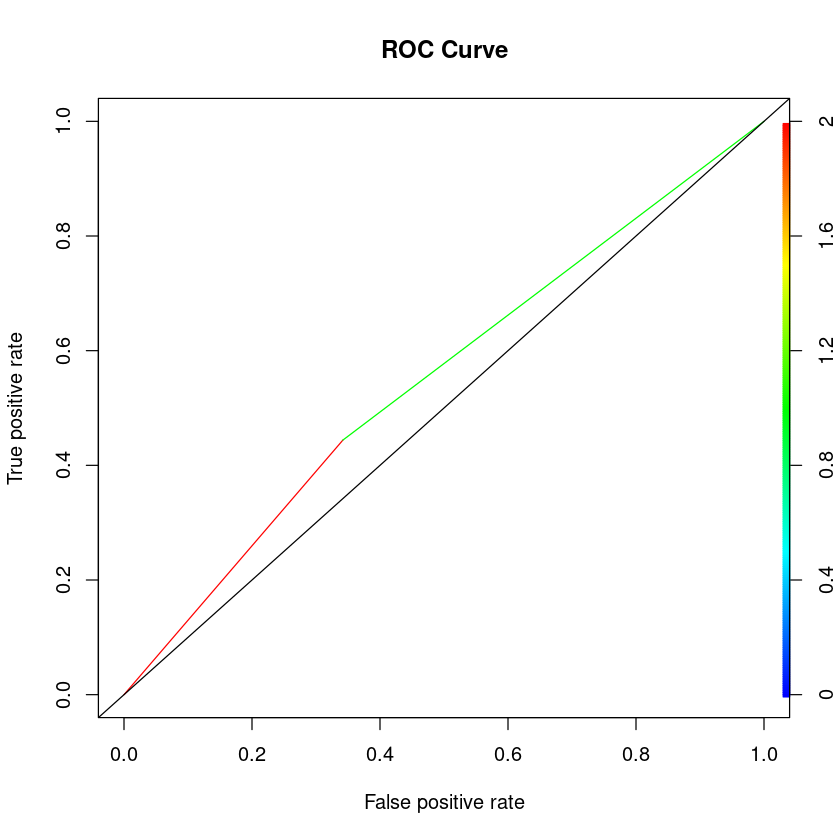

In [23]:
modelPerformance(h1escmodel2Under, "lr", test, Class)

This case is somewhat balanced, not only in terms of respective data points but also sensivitiy and specificity of the classifier.

##### <a id=link8> 4.1.3 SMOTE  </a>

The sampling techniques are straighforward, but could possibly engender a classifier that overfits the training data and hence might not be suitable for a general application. To handle such a chance, [SMOTE](https://www3.nd.edu/~dial/publications/chawla2002smote.pdf) was introduced by Chawla et al. in 2002 and the functionality is available in R with the package *DMwR*.

In [24]:
## Smote : Synthetic Minority Oversampling Technique
## A pre-requisite is that the class variable in the data must be of "factor" category. Let's do that conversion.

train$Class <- as.factor(train$Class)

smoteData <- SMOTE(Class ~., train, perc.over = 100000, k = 5, perc.under = 100)

table(smoteData$Class)


      0       1 
2926000 2928926 

In [25]:
h1escmodel1SMOTE <- glm(formula = Class ~ CTCF + EP300 + H3K27me3 + H3K36me3 + H3K4me1 + H3K4me2 + H3K4me3 + H3K9ac + H3K9me3 + RAD21 + RNAPol2,
               data = smoteData,
               family = "binomial")
summary(h1escmodel1SMOTE)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”



Call:
glm(formula = Class ~ CTCF + EP300 + H3K27me3 + H3K36me3 + H3K4me1 + 
    H3K4me2 + H3K4me3 + H3K9ac + H3K9me3 + RAD21 + RNAPol2, family = "binomial", 
    data = smoteData)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-8.4904  -1.1384   0.3055   1.1744   1.5494  

Coefficients:
              Estimate Std. Error  z value Pr(>|z|)    
(Intercept) -0.5904036  0.0017942 -329.070  < 2e-16 ***
CTCF        -0.0872603  0.0011346  -76.910  < 2e-16 ***
EP300        0.5787244  0.0022852  253.245  < 2e-16 ***
H3K27me3     0.0294589  0.0004091   72.003  < 2e-16 ***
H3K36me3     0.1748372  0.0011352  154.013  < 2e-16 ***
H3K4me1      0.0538817  0.0014811   36.379  < 2e-16 ***
H3K4me2     -0.0875227  0.0011761  -74.417  < 2e-16 ***
H3K4me3      0.1285948  0.0015412   83.438  < 2e-16 ***
H3K9ac      -0.0121846  0.0018959   -6.427  1.3e-10 ***
H3K9me3     -0.0247123  0.0016849  -14.667  < 2e-16 ***
RAD21        0.1162848  0.0013551   85.812  < 2e-16 ***
RNAPol2     -0.064

Let us now examine this model with the test data.

In [26]:
vif(h1escmodel1SMOTE)

CTCF     EP300  H3K27me3  H3K36me3   H3K4me1   H3K4me2   H3K4me3    H3K9ac 
 3.301714  1.774807  1.255446  1.222166  2.196314  7.817990 10.834065  4.696277 
  H3K9me3     RAD21   RNAPol2 
 1.154142  3.446405  2.928852

The confusion matrix is
         Actual
Predicted      0      1
        0 286223    623
        1 177432    609
The accuracy of the model is 61.69929 % 
The misclassification error of the model is 38.30071 % 
The sensitivity of the model is 61.73189 % 
The specificity of the model is 49.43182 % 
The area under curve is 0.5558185 
The statistical significance for the model is 0 
The confidence level for the model is 100 %

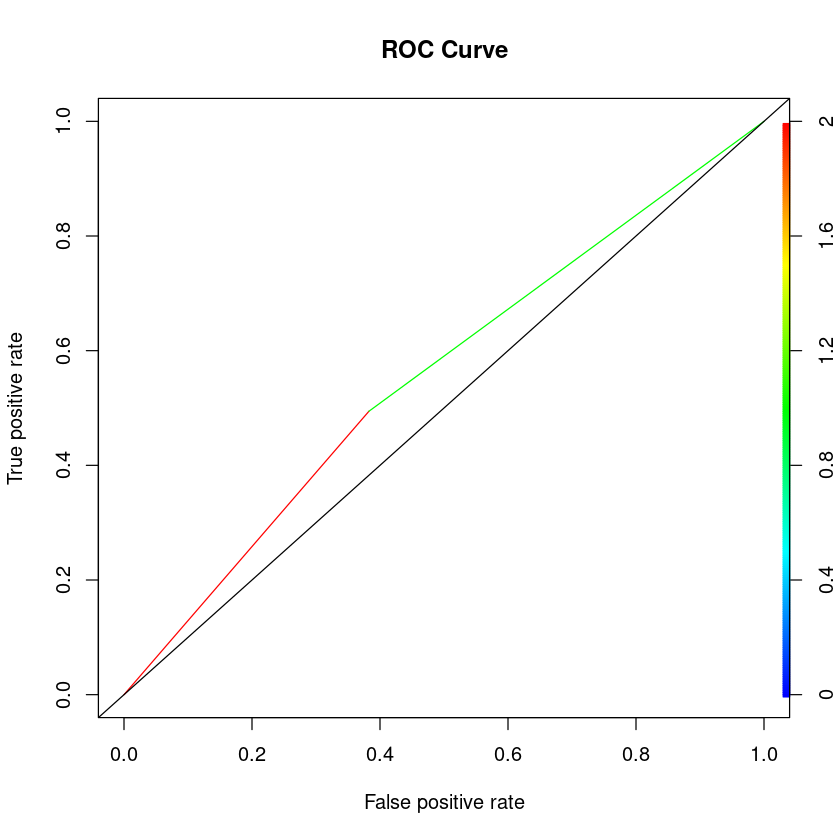

In [27]:
modelPerformance(h1escmodel1SMOTE, "lr", test, Class)

##### <a id=link9> 4.1.4 Both over- and under-sampling </a>

This model has slightly better specificity than the previous model. In tandem, we could also try yet another flavor of the *ovun.sample()* function - to have under- and over-sampling both in parallel. This could be a likely run like the SMOTE as above.

In [28]:
bothTrain <- ovun.sample(Class ~., data = train, method = "both", N= 1081609)$data
table(bothTrain$Class)


     0      1 
540688 540921 

In [29]:
h1escmodel1Both <- glm(formula = Class ~ CTCF + EP300 + H3K27me3 + H3K36me3 + H3K4me1 + H3K4me2 + H3K4me3 + H3K9ac + H3K9me3 + RAD21 + RNAPol2,
               data = bothTrain,
               family = "binomial")
summary(h1escmodel1Both)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”



Call:
glm(formula = Class ~ CTCF + EP300 + H3K27me3 + H3K36me3 + H3K4me1 + 
    H3K4me2 + H3K4me3 + H3K9ac + H3K9me3 + RAD21 + RNAPol2, family = "binomial", 
    data = bothTrain)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-8.4904  -1.1368   0.2493   1.1768   1.4916  

Coefficients:
              Estimate Std. Error  z value Pr(>|z|)    
(Intercept) -0.5805421  0.0041411 -140.191  < 2e-16 ***
CTCF        -0.0696009  0.0024901  -27.951  < 2e-16 ***
EP300        0.5415484  0.0052485  103.181  < 2e-16 ***
H3K27me3     0.0311855  0.0009445   33.018  < 2e-16 ***
H3K36me3     0.1757562  0.0026200   67.082  < 2e-16 ***
H3K4me1      0.0514695  0.0033489   15.369  < 2e-16 ***
H3K4me2     -0.0647103  0.0025537  -25.340  < 2e-16 ***
H3K4me3      0.0920145  0.0032599   28.226  < 2e-16 ***
H3K9ac      -0.0061580  0.0042516   -1.448    0.148    
H3K9me3     -0.0202228  0.0038772   -5.216 1.83e-07 ***
RAD21        0.1016506  0.0029677   34.252  < 2e-16 ***
RNAPol2     -0.043

In [30]:
vif(h1escmodel1Both)

CTCF    EP300 H3K27me3 H3K36me3  H3K4me1  H3K4me2  H3K4me3   H3K9ac 
3.015470 1.774450 1.239172 1.188857 2.060173 7.045854 9.624342 4.619262 
 H3K9me3    RAD21  RNAPol2 
1.147561 3.184918 2.722726

The confusion matrix is
         Actual
Predicted      0      1
        0 289976    632
        1 173679    600
The accuracy of the model is 62.50465 % 
The misclassification error of the model is 37.49535 % 
The sensitivity of the model is 62.54133 % 
The specificity of the model is 48.7013 % 
The area under curve is 0.5562131 
The statistical significance for the model is 0 
The confidence level for the model is 100 %

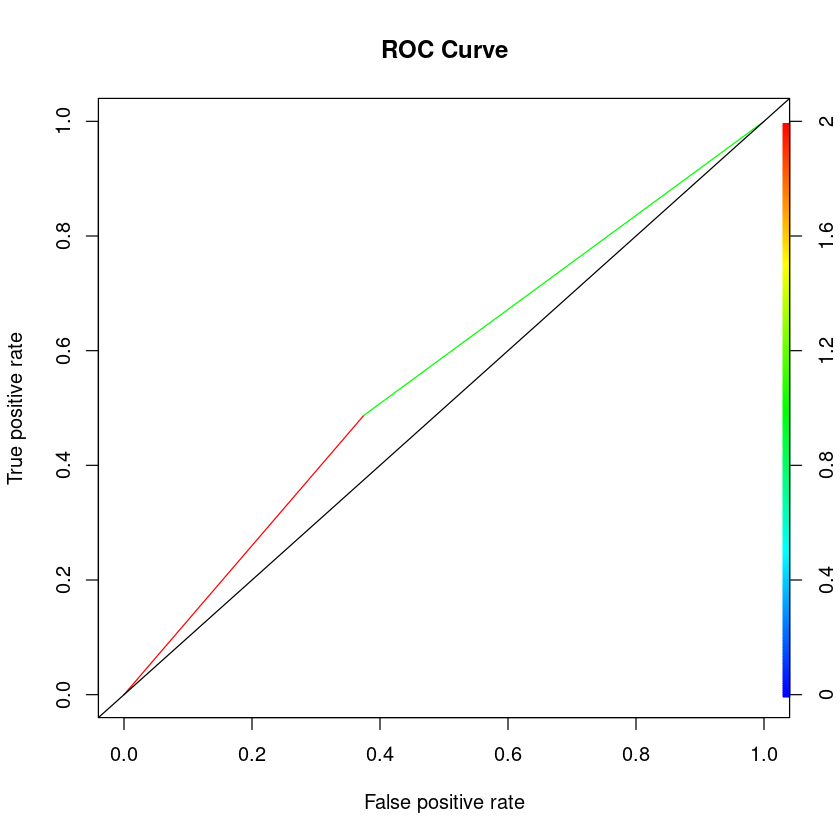

In [31]:
modelPerformance(h1escmodel1Both, "lr", test, Class)

These numbers aren't as good. Hitherto, the model with SMOTE data has performed the best.

### <a id=link10>5. Ratifying the *Pareto's Principle* </a>

The 80:20 rule is omnipresent in the domains of business and economy. Hardly would have the italian economist known at the time that his [theory](https://en.wikipedia.org/wiki/Pareto_principle) would be rooted deeper than his perception. 

In [32]:
set.seed(6) # for reproducibility of results.
parts <- sample(2, nrow(h1escgreg),
               replace = TRUE,
               prob = c(0.8,0.2))
training <- h1escgreg[parts==1,]
testing <- h1escgreg[parts==2,]
cat("So, now we have", nrow(training), "training rows and", nrow(testing), "testing rows")

So, now we have 1239682 training rows and 309740 testing rows

In [33]:
h1escparetoModel <- glm(formula = Class ~ CTCF + EP300 + H3K27me3 + H3K36me3 + H3K4me1 + H3K4me2 + H3K4me3 + H3K9ac + H3K9me3 + RAD21 + RNAPol2, 
                        data = training, 
                        family = "binomial")
summary(h1escparetoModel)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”



Call:
glm(formula = Class ~ CTCF + EP300 + H3K27me3 + H3K36me3 + H3K4me1 + 
    H3K4me2 + H3K4me3 + H3K9ac + H3K9me3 + RAD21 + RNAPol2, family = "binomial", 
    data = training)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.3222  -0.0744  -0.0713  -0.0679   3.9134  

Coefficients:
             Estimate Std. Error  z value Pr(>|z|)    
(Intercept) -6.128105   0.026936 -227.503  < 2e-16 ***
CTCF        -0.089985   0.021505   -4.184 2.86e-05 ***
EP300        0.048816   0.014586    3.347 0.000818 ***
H3K27me3     0.015242   0.004568    3.337 0.000847 ***
H3K36me3     0.077050   0.016106    4.784 1.72e-06 ***
H3K4me1      0.163138   0.022919    7.118 1.09e-12 ***
H3K4me2     -0.036044   0.016398   -2.198 0.027947 *  
H3K4me3      0.119361   0.017929    6.657 2.79e-11 ***
H3K9ac      -0.145488   0.027256   -5.338 9.41e-08 ***
H3K9me3      0.012040   0.028776    0.418 0.675646    
RAD21        0.123385   0.021203    5.819 5.91e-09 ***
RNAPol2     -0.012022   0.01130

The confusion matrix is
         Actual
Predicted      0      1
        0 463651   1232
        1      4      0
The accuracy of the model is 99.73413 % 
The misclassification error of the model is 0.2658711 % 
The sensitivity of the model is 99.99914 % 
The specificity of the model is 0 % 
The area under curve is 0.4999957 
The statistical significance for the model is 3.384964e-52 
The confidence level for the model is 100 %

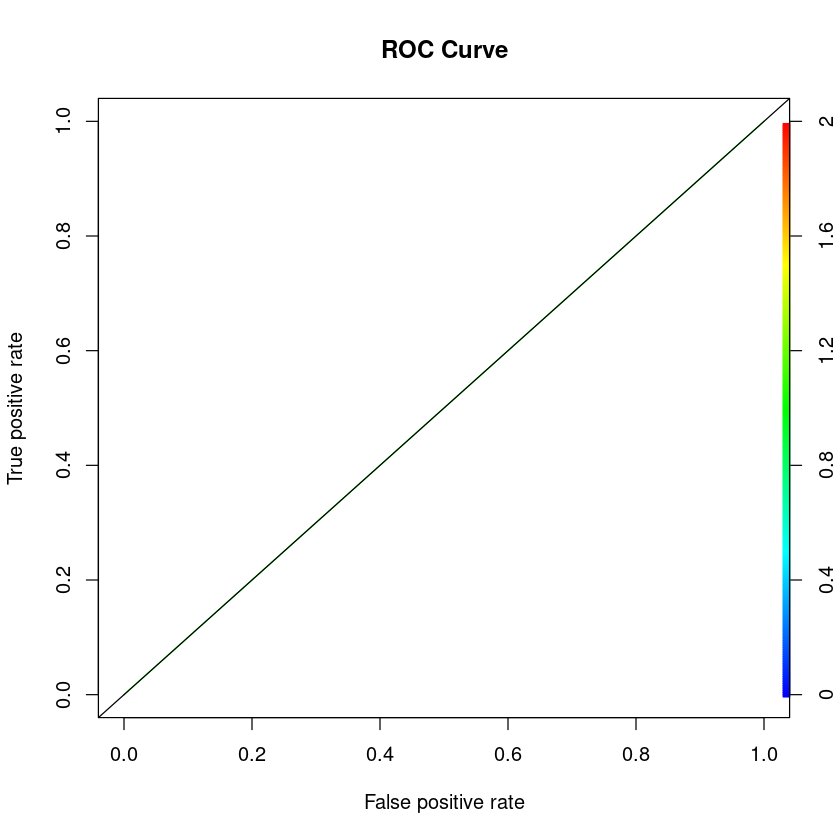

In [34]:
modelPerformance(h1escparetoModel, "lr", test, Class)

We see here that the issue of class imbalance imposes skewness on the classifier to predict solely non-hubs (represented by "0"). The balancing of the data, as practiced above, might come to the rescue. Let's examine the performance of the classifier on SMOTE transformed data.

#### <a id=link11>5.1 SMOTE data </a>

In [35]:
training$Class <- as.factor(training$Class)
smoteDatum <- SMOTE(Class ~ CTCF + EP300 + H3K27me3 + H3K36me3 + H3K4me1 + H3K4me2 + H3K4me3 + H3K9ac + H3K9me3 + RAD21 + RNAPol2, 
                    training, 
                    perc.over = 10000, 
                    k = 7, 
                    perc.under = 99)
table(smoteDatum$Class)


     0      1 
328581 335219 

In [36]:
h1escparetoModelSmote <- glm(formula = Class ~ CTCF + EP300 + H3K27me3 + H3K36me3 + H3K4me1 + H3K4me2 + H3K4me3 + H3K9ac + H3K9me3 + RAD21 + RNAPol2, 
                             data = smoteDatum, 
                             family = "binomial")
summary(h1escparetoModelSmote)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”



Call:
glm(formula = Class ~ CTCF + EP300 + H3K27me3 + H3K36me3 + H3K4me1 + 
    H3K4me2 + H3K4me3 + H3K9ac + H3K9me3 + RAD21 + RNAPol2, family = "binomial", 
    data = smoteDatum)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-8.4904  -1.1465   0.6146   1.1648   1.9401  

Coefficients:
             Estimate Std. Error  z value Pr(>|z|)    
(Intercept) -0.539949   0.005287 -102.129  < 2e-16 ***
CTCF        -0.133624   0.003468  -38.534  < 2e-16 ***
EP300        0.580774   0.006825   85.091  < 2e-16 ***
H3K27me3     0.020617   0.001166   17.683  < 2e-16 ***
H3K36me3     0.117575   0.003320   35.411  < 2e-16 ***
H3K4me1      0.073903   0.004334   17.054  < 2e-16 ***
H3K4me2     -0.051152   0.003610  -14.170  < 2e-16 ***
H3K4me3      0.075014   0.004637   16.177  < 2e-16 ***
H3K9ac       0.006399   0.005593    1.144  0.25253    
H3K9me3     -0.014825   0.004958   -2.990  0.00279 ** 
RAD21        0.152519   0.004142   36.818  < 2e-16 ***
RNAPol2     -0.064713   0.002

In [37]:
vif(h1escparetoModelSmote)

CTCF     EP300  H3K27me3  H3K36me3   H3K4me1   H3K4me2   H3K4me3    H3K9ac 
 3.378569  1.788870  1.242397  1.205308  2.111154  8.377959 10.167460  4.062471 
  H3K9me3     RAD21   RNAPol2 
 1.150138  3.568909  2.533111

The confusion matrix is
         Actual
Predicted      0      1
        0 273534    573
        1 190121    659
The accuracy of the model is 58.98057 % 
The misclassification error of the model is 41.01943 % 
The sensitivity of the model is 58.99516 % 
The specificity of the model is 53.49026 % 
The area under curve is 0.5624271 
The statistical significance for the model is 0 
The confidence level for the model is 100 %

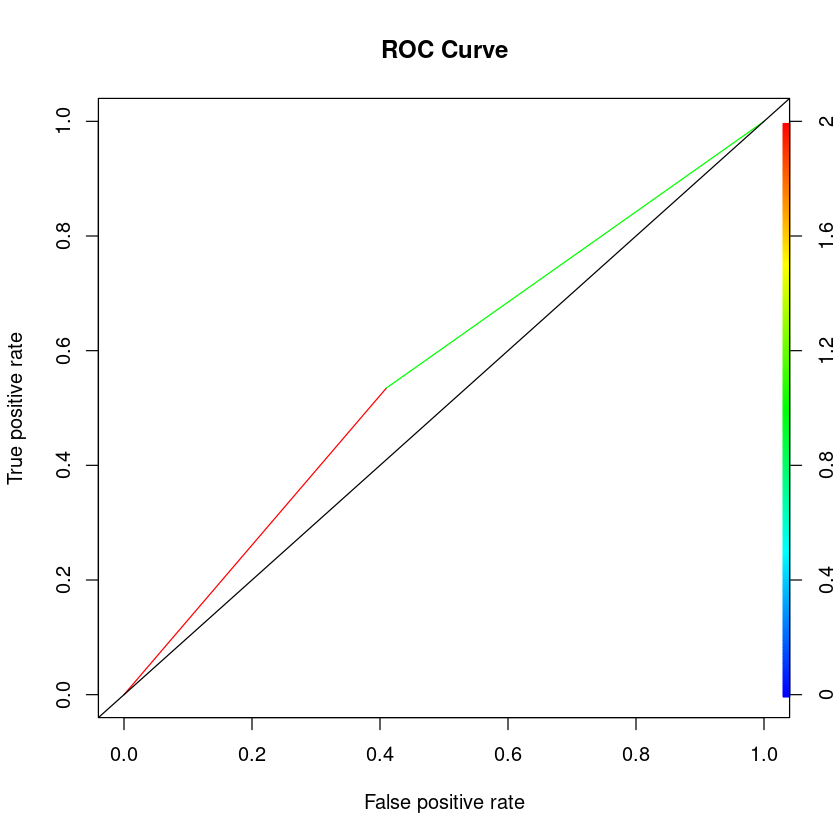

In [38]:
modelPerformance(h1escparetoModelSmote, "lr", test, Class)

### <a id=link12>6. Visualizing Predictions </a>

We choose to go with the current model and will save the prediction results, that shall be later utilized for plotting.

In [39]:
h1escgregModelPredictions <- predict(h1escparetoModelSmote, h1escgreg, type = "response")
h1escgregModelPredictionsProbs <- ifelse(h1escgregModelPredictions > 0.5, 1, 0)

Eventually, we have the original dataset with the classes and the one with the model predictions. We attempt to map the prediction results corresponding to LR-Hubs from the H1ESC cell-line. It will be interesting to see the intersect of the pre-caliberated LR-Hubs and the ones predicted by the classifier.

The workflow commences with the installation of <a href = "http://www.bioconductor.org/packages/release/bioc/html/Gviz.html" > Gviz</a> - the package we aim to deploy for the visualization.

In [40]:
if(!requireNamespace("BiocManager", quietly = TRUE))
BiocManager::install("Gviz")
suppressPackageStartupMessages(library(Gviz))

Next, we recall the data from the H1ESC cell-line (GREG). We already know, this is a comprehensive data (genome-wide) with values corresponding to epigenetic marks (features) for each bin (a 2Kb genomic region), in addition to a "Class", i.e. a "Hub" or a "Non-Hub". For the present case, we shall prune the data for the genomic intervals and their corresponding class. That is all we need!

In [41]:
h1escgregStandardRegionsClass <- h1escgregStandard[, c(1:3,17)]

Also, considering the computational resources we deploy, we shall focus on chromosome 21 only.

In [42]:
# Extracting chr21 data

h1escgregChr21NonHub <- h1escgregStandardRegionsClass[h1escgregStandardRegionsClass$chr=="chr21" & h1escgregStandardRegionsClass$Class=="Non-Hub", ] ## subset of data for exemplifying
h1escgregChr21Hub <- h1escgregStandardRegionsClass[h1escgregStandardRegionsClass$chr=="chr21" & h1escgregStandardRegionsClass$Class=="Hub", ]

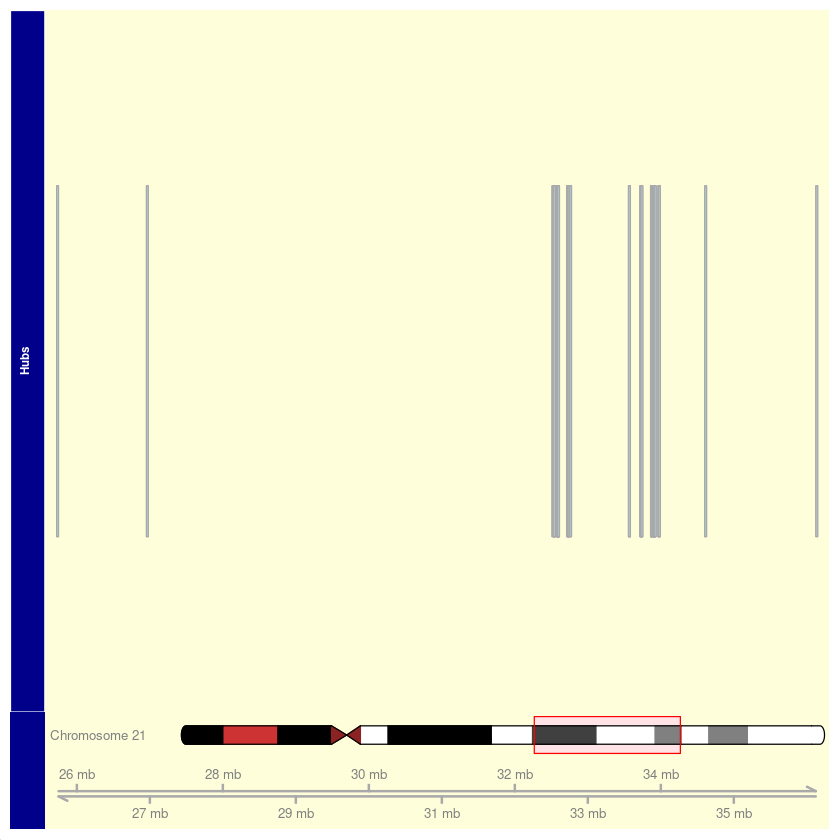

In [43]:
# Plotting Hubs

annotationTrackHub <- AnnotationTrack(range = h1escgregChr21Hub, 
                                      name = "Hubs", 
                                      genome = "hg38", 
                                      chromosome = "chr21")
itrack <- IdeogramTrack(genome = "hg38", chromosome = "chr21")
genomeTrack <- GenomeAxisTrack()
plotTracks(list(annotationTrackHub, itrack, genomeTrack), 
           background.panel = "#FFFEDB", 
           background.title = "darkblue",
           stacking = "dense")

So, there is a narrow occurrence of "hubs" in the chromosome 21, as seen above. The specific locations are given below.

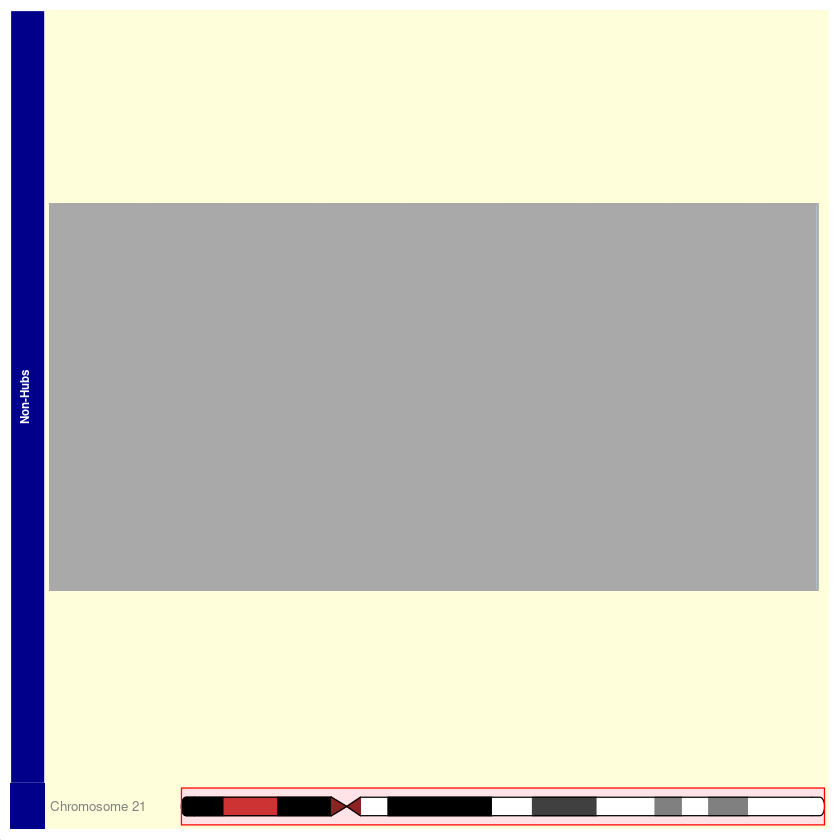

In [44]:
# Plotting Non-Hubs

annotationTrackNonHub <- AnnotationTrack(range = h1escgregChr21NonHub, 
                                         name = "Non-Hubs", 
                                         genome = "hg38", 
                                         chromosome = "chr21")
itrack <- IdeogramTrack(genome = "hg38", chromosome = "chr21")
plotTracks(list(annotationTrackNonHub, itrack),
           background.panel = "#FFFEDB", 
           background.title = "darkblue",
           stacking = "dense")

In contrast, we are curious to examine if the findings of the classifier are able to fortify the original class definitions. Let us frame the data from the predicted results.  

In [45]:
h1escgregPredicted <- cbind(h1escgregStandardRegionsClass, h1escgregModelPredictionsProbs)
names(h1escgregPredicted)[names(h1escgregPredicted)=="h1escgregModelPredictionsProbs"] <- "Prediction"
h1escgregPredicted$Prediction <- ifelse(h1escgregPredicted$Prediction == 1, "Hub", "Non-Hub")            

Let us see if the classifier predictions match with the original results.

In [46]:
h1escgregChr21PredicitedHub <- h1escgregPredicted[h1escgregPredicted$chr=="chr21" & h1escgregPredicted$Prediction=="Hub", ]

Certainly, the predicted hubs are far more in number and there are noticeable instances of "Non-Hubs" that have been classified as "Hubs", with the given profile of the classification model.  

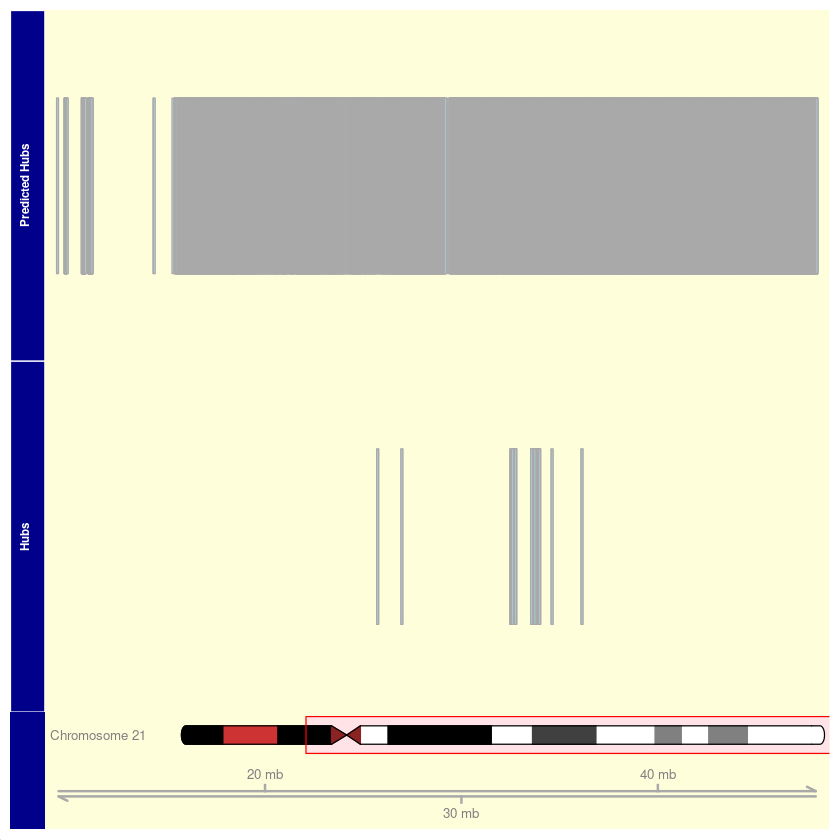

In [47]:
# Plotting Predicted Hubs
annotationTrackHub <- AnnotationTrack(range = h1escgregChr21Hub, 
                                      name = "Hubs", 
                                      genome = "hg38", 
                                      chromosome = "chr21")
annotationTrackPredictedHub <- AnnotationTrack(range = h1escgregChr21PredicitedHub, 
                                               name = "Predicted Hubs", 
                                               genome = "hg38", 
                                               chromosome = "chr21")
itrack <- IdeogramTrack(genome = "hg38", chromosome = "chr21")
genomeTrack <- GenomeAxisTrack()
plotTracks(list(annotationTrackPredictedHub,annotationTrackHub, itrack, genomeTrack), 
           background.panel = "#FFFEDB", 
           background.title = "darkblue",
           stacking = "dense")

In [49]:
truePositives <- h1escgregPredicted[h1escgregPredicted$Class == h1escgregPredicted$Prediction, ]

As we close, we'll save the optimal model and true positive genomic regions (hubs) as explicit R data objects, in order to recall for later use.

In [50]:
## Saving relevant files

save(h1escparetoModelSmote, file = "./optimalModels/h1escmodelLR") # optimal model
write.table(truePositives, file = "./truePositives/h1escLR.txt", quote = FALSE) # true positives: precicted ~ original
write.table(smoteDatum, file = "./buildData/optimalModelTrainH1ESC.txt", quote = FALSE) # data used to train model
write.table(test, file = "./buildData/optimalModelTestH1ESC.txt", quote = FALSE) # data used to test model

### Conclusion

We see that the best performing model isn't just graded by its accuracy (which is corresponding to the current state of class distribution), but by how well it is able to differentiate between the negative and positive classes. Considering the same as premise, we identified that the following is the best performing model with related attributes.

| Best Model | Accuracy | Sensitivity | Specificity | Remark
| --- | --- | --- | --- | ---
| h1escparetoModelSmote | 58.98057 % | 58.99516 % | 53.49026 % | Good

Also, note that data on which the model was trained has a distribution of 328581:335219 in class proportion, which is 1.02020202 (~1). So, the probability of finding any class is 50% (ideally) because we have a near homogeneous spread of class labels.  

### <a id=link13>7. Session Information </a>

In [141]:
sessionInfo()

R version 4.0.2 (2020-06-22)
Platform: x86_64-apple-darwin17.0 (64-bit)
Running under: macOS Catalina 10.15.6

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.0/Resources/lib/libRblas.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/4.0/Resources/lib/libRlapack.dylib

locale:
[1] C/UTF-8/C/C/C/C

attached base packages:
 [1] parallel  stats4    grid      stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] Gviz_1.32.0          GenomicRanges_1.40.0 GenomeInfoDb_1.24.2 
 [4] IRanges_2.22.2       S4Vectors_0.26.1     BiocGenerics_0.34.0 
 [7] DMwR_0.4.1           ROCR_1.0-11          ROSE_0.0-3          
[10] e1071_1.7-3          caret_6.0-86         rms_6.0-1           
[13] SparseM_1.78         Hmisc_4.4-1          ggplot2_3.3.2       
[16] Formula_1.2-3        survival_3.2-3       lattice_0.20-41     
[19] glmnet_4.0-2         Matrix_1.2-18       

loaded via a namespace (and not attached):
  [1] uui